In [ ]:
import matplotlib.pyplot as plt

import pandas as pd
import re

import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.stem import WordNetLemmatizer, SnowballStemmer                          
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize.casual import casual_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud


from sklearn.metrics.cluster import homogeneity_score, completeness_score, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, NMF
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\radus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# All functions required to preprocess the data

stemmer = SnowballStemmer("english")
english_stop_words = set(stopwords.words('english'))

def clean_str(string):
  string = re.sub(r"\'s", "", string)
  string = re.sub(r"\'ve", "", string)
  string = re.sub(r"n\'t", "", string)
  string = re.sub(r"\'re", "", string)
  string = re.sub(r"\'d", "", string)
  string = re.sub(r"\'ll", "", string)
  string = re.sub(r",", "", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", "", string)
  string = re.sub(r"\)", "", string)
  string = re.sub(r"\?", "", string)
  string = re.sub(r"'", "", string)
  string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
  string = re.sub(r"[0-9]\w+|[0-9]","", string)
  string = re.sub(r"\s{2,}", " ", string)
  return string.strip().lower()

def lemmatize_stemming(word):
  return stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))
    
def preprocess(sentence):
  processed = []
  sentence = clean_str(sentence)
  for word in word_tokenize(sentence):
      if word not in english_stop_words and len(word) > 3:
          processed.append(lemmatize_stemming(word))
  return processed

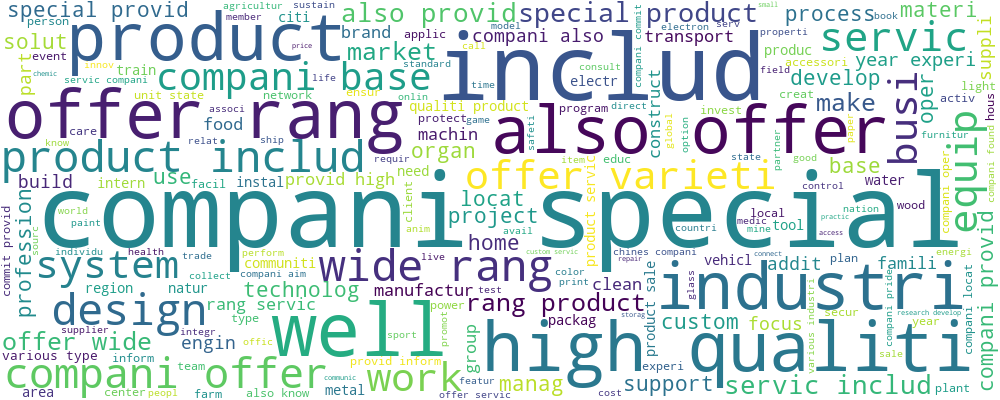

In [45]:
# Reading and preprocessing the data
data = pd.read_csv('Data/ml_insurance_challenge.csv')
labels_raw = pd.read_csv('./Data/insurance_taxonomy - insurance_taxonomy.csv')

data['description'] = data['description'].fillna('None')

data.head()

processed_data = data['description'].map(preprocess)
processed_labels = labels_raw['label'].map(preprocess)

TempData = []
for i in range(len(processed_data)):
  sentence = TreebankWordDetokenizer().detokenize(processed_data[i])
  TempData.append(sentence)

df = pd.DataFrame(data = TempData, columns = ['description'])

TempData = []
for i in range(len(processed_labels)):
  sentence = TreebankWordDetokenizer().detokenize(processed_labels[i])
  TempData.append(sentence)

df_labels = pd.DataFrame(data = TempData, columns = ['labels'])

wc = WordCloud(background_color='white', width=1000, height=400, stopwords=english_stop_words)
wc.generate(" ".join(row['description'] for index,row in df.iterrows())).to_image()

My initial idea was to use K-means clustering, however it is not suited for multilabel classification.

c:\Users\radus\OneDrive\Desktop\AI\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Text(0, 0.5, 'Inertia')

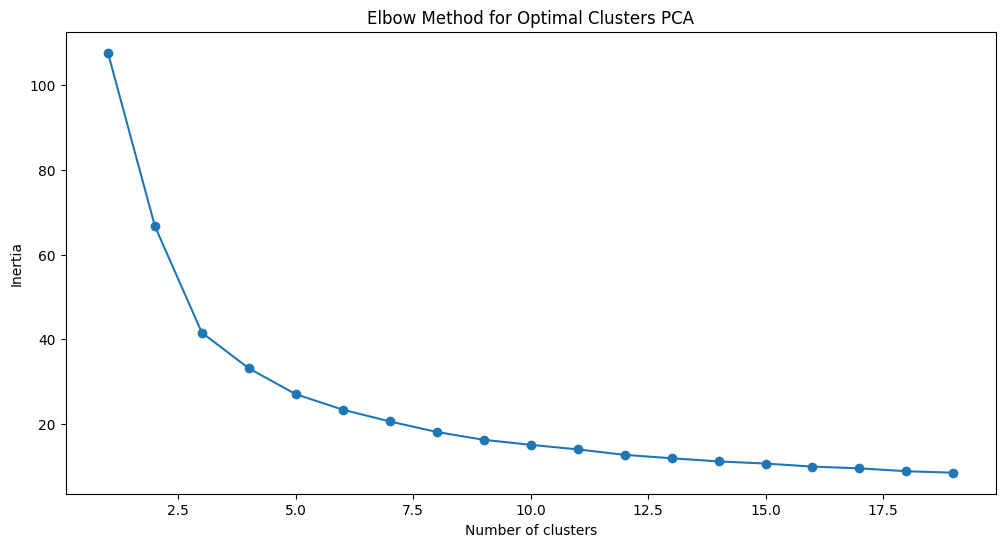

In [ ]:
# Training K-means on the PCA transformed data
vectorizer = TfidfVectorizer(tokenizer=casual_tokenize)

vocabulary = vectorizer.fit(df['description'])
dataTFIDF = vocabulary.transform(df['description']).toarray()

pca = PCA(n_components=2)
pca.fit(dataTFIDF)
dataPCA = pca.transform(dataTFIDF)

inertia = []
clusters = []
for cluster in range(1,20):
    k_means = KMeans(n_clusters = cluster)
    k_means.fit(dataPCA)
    inertia.append(k_means.inertia_)
    clusters.append(cluster)

plt.figure(figsize=(12,6))
plt.plot(clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters PCA')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

K-Means separates the data into 8 distinct clusters, and each cluster might correspond to multiple labels. However, I currently lack a reliable method to determine which labels are specifically associated with these clusters.

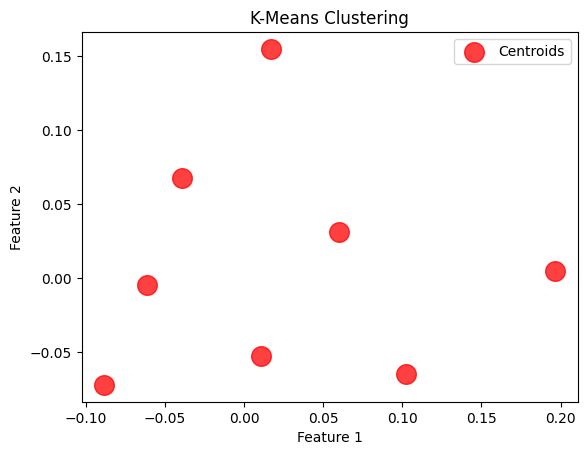

In [22]:
k_meansPCA = KMeans(n_clusters = 8, random_state = 42)
k_meansPCA.fit(dataPCA)

predictedPCA = k_meansPCA.predict(dataPCA)

centers = k_meansPCA.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, label='Centroids')

# Customize the plot
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


However we can force KMean to have 221 cluster (the number of labels). This approach might not generalize well for new data.
Also as we can se below, the clusters heavily overlap

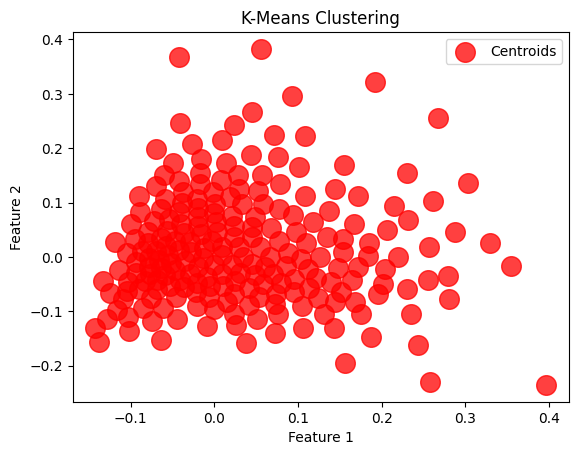

In [23]:
k_meansPCA = KMeans(n_clusters = 221, random_state = 42)
k_meansPCA.fit(dataPCA)

predictedPCA = k_meansPCA.predict(dataPCA)

centers = k_meansPCA.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, label='Centroids')

# Customize the plot
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


Another option could be to use DBSCAN but it would have the same problems as KMean

In [ ]:
# Training DBSCAN on the t-SNE transformed data
vectorizer = TfidfVectorizer()

vocabulary = vectorizer.fit(df['description'])
dataTFIDF = vocabulary.transform(df['description']).toarray()

dataTSNE = TSNE(random_state=42).fit_transform(dataTFIDF)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(dataTSNE)

distances, indices = neighbors_fit.kneighbors(dataTSNE)
distances = np.sort(distances, axis=0)
distances= distances[:,1]

Text(0, 0.5, 'Distance')

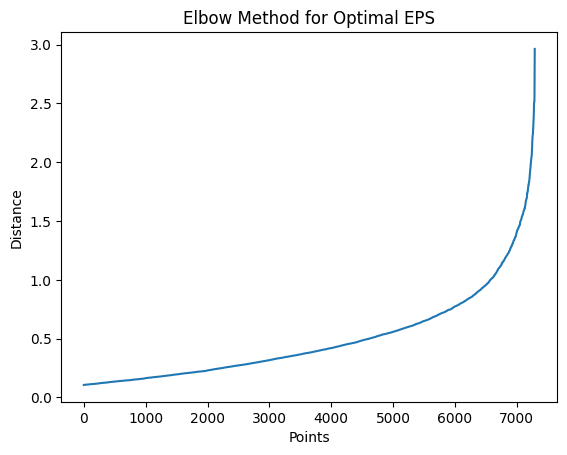

In [ ]:
plt.plot(distances[2200:-2]) 
plt.title('Elbow Method for Optimal EPS')
plt.xlabel('Points')
plt.ylabel('Distance')

Estimated number of clusters: 222


C:\Users\radus\AppData\Local\Temp\ipykernel_1336\2487317888.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_labels))  # Use a colormap for cluster colors


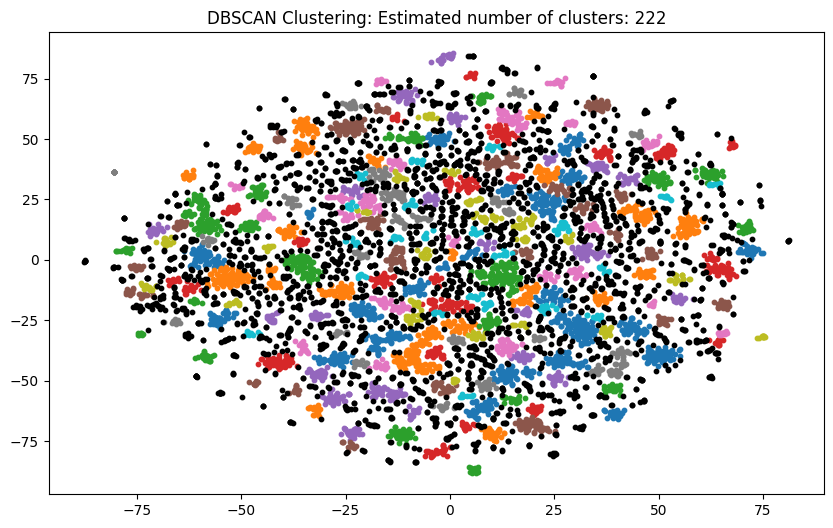

In [43]:
from matplotlib import cm

dbscan = DBSCAN(eps=2, min_samples=12).fit(dataTSNE)
predictedDBSCAN = dbscan.labels_

n_clusters_ = len(set(predictedDBSCAN)) - (1 if -1 in predictedDBSCAN else 0)

print('Estimated number of clusters: %d' % n_clusters_)
# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(predictedDBSCAN)
colors = cm.get_cmap('tab10', len(unique_labels))  # Use a colormap for cluster colors

for label in unique_labels:
    if label == -1:
        # Noise points
        color = 'black'
        label_name = 'Noise'
    else:
        color = colors(label)
        label_name = f'Cluster {label}'
    
    cluster_points = dataTSNE[predictedDBSCAN == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, c=[color], label=label_name)

plt.title('DBSCAN Clustering: Estimated number of clusters: %d' % n_clusters_)
plt.show()

Again, not a great way to determine the actual labels now. But at least we are closer to the actual number of labels.

https://github.com/sebischair/Lbl2Vec

A possible solution to this problem could be the link above, but I counld not workout the dependencies for Lbl2Vec

Other options:

Deep Embedded Clustering (DEC) /
Variational Autoencoders (VAEs) /
Matrix Factorization



Other opion would be to change the dataset as an input for a GPT model with the propmpt:

Given these list of labes what would fit given the desciption, keywords etc.